In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Load and preprocess the dataset
df = pd.read_csv('Cleaned_MCS_TEAM_DATA.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df = df.sort_values(by='DATETIME')
df.set_index('DATETIME', inplace=True)

# Define features and target
features = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']
target = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']

# Normalize the numerical features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Time steps and data generator setup
time_steps = 21
data_gen = TimeseriesGenerator(df[features].values, df[target].values, length=time_steps, batch_size=64)

# Build LSTM-GRU hybrid model
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(time_steps, len(features))))
model.add(Dropout(0.2))
model.add(GRU(120))
model.add(Dropout(0.2))
model.add(Dense(len(features)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(data_gen, epochs=100)
print(model.summary())

# Forecast function with inverse transformation
def forecast_weather(model, data, scaler, steps=21):
    forecast = []
    last_sequence = data[-steps:].values  # Extract and convert to NumPy array

    # Reshape for model input
    last_sequence = last_sequence[np.newaxis, :, :]

    for _ in range(steps):
        prediction = model.predict(last_sequence)
        forecast.append(prediction[0])
        last_sequence = np.append(last_sequence[:, 1:, :], prediction[:, np.newaxis, :], axis=1)

    # Create forecast DataFrame and inverse transform
    forecast_df = pd.DataFrame(forecast, columns=features)
    forecast_df = pd.DataFrame(scaler.inverse_transform(forecast_df), columns=features)

    # Add dates to the DataFrame for context
    last_date = data.index[-1]
    forecast_dates = pd.date_range(start=df.index.max() + pd.Timedelta(hours=8), periods=time_steps, freq='8h')
    forecast_df['DATETIME'] = forecast_dates

    return forecast_df

# Usage example:
forecast_results = forecast_weather(model, df, scaler)
print(forecast_results)

# Save the forecast to a CSV file
forecast_results.to_csv('LSTM_GRU_forecast_results.csv', index=False)


Epoch 1/100


2024-11-04 10:00:42.681444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 10:00:42.681856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 10:00:42.682487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 [==============================] - 2s 28ms/step - loss: 0.0761
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0395
Epoch 3/100
29/29 [==============================] - 1s 29ms/step - loss: 0.0377
Epoch 4/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0364
Epoch 5/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0360
Epoch 6/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0362
Epoch 7/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0352
Epoch 8/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0352
Epoch 9/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0345
Epoch 10/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0343
Epoch 11/100
29/29 [==============================] - 1s 33ms/step - loss: 0.0334
Epoch 12/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0339
Epoch 13/100
29/29 [=================

2024-11-04 10:02:20.312023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-04 10:02:20.312528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-04 10:02:20.313026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 8ms/step
    TEMPERATURE (°C)  RAINFALL (mm)  ACTUAL CONDITION  OCCURENCE OF FLOOD  \
0          30.228649       1.087519          2.120795            0.966269   
1          30.842896       1.875303          2.692993            0.911463   
2          28.995575       3.317535          2.303600            0.856664   
3          29.312349       3.456939          2.559990            0.856021   
4          30.145199       3.133887          2.737985            0.868544   
5          30.016357       2.914212          2.664620            0.874840   
6          30.234648       2.631246          2.693336            0.889147   
7          30.813271       2.384268          2.788813            0.904106   
8          30.822575       2.165093          2.830259            0.912604   
9          31.058231       2.005467          2.949773            0.921490   
10         31.001663       1.862465          3.025662            0.926354   
11         30.908165     

Actual Data Columns: Index(['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION',
       'OCCURENCE OF FLOOD'],
      dtype='object')


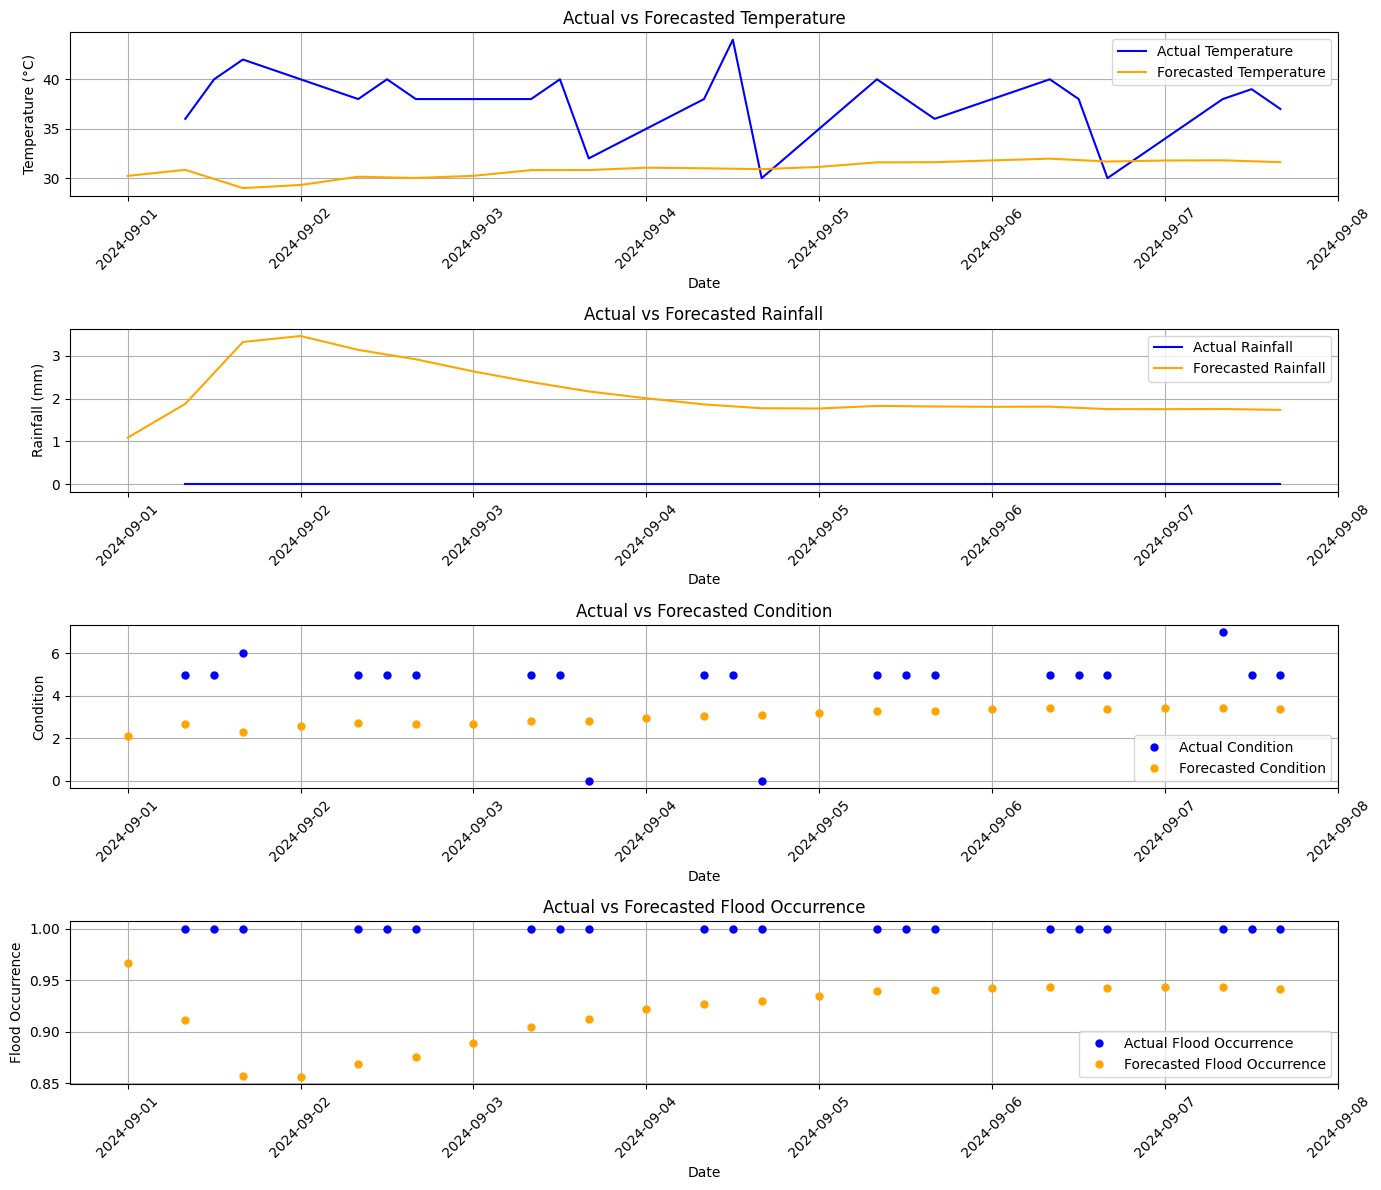

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Check the columns of the actual data
print("Actual Data Columns:", actual_data.columns)

# Assuming forecast_df is already defined and contains the forecasted data
# For demonstration purposes, you may need to define it or load it from another source
# Example structure of forecast_df for context (replace this with actual loading code):
# forecast_df = pd.read_csv('Forecasted_Data.csv')  # Load your forecast data here
# print("Forecast Data Columns:", forecast_df.columns)

# Check the columns of the forecasted data
# print("Forecast Data Columns:", forecast_df.columns)

# Convert 'DATETIME' columns to datetime objects for proper plotting
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Ensure forecast_df is defined and structured correctly
# Assuming forecast_df is defined with a proper structure
# forecast_df['DATETIME'] = pd.to_datetime(forecast_df['DATETIME'])

# Check if DATETIME column exists in forecast_df
if 'DATETIME' not in forecast_results.columns:
    print("Error: 'DATETIME' column not found in forecast_df")
else:
    forecast_results['DATETIME'] = pd.to_datetime(forecast_results['DATETIME'])

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
forecast_results.set_index('DATETIME', inplace=True)

# Create a figure with four subplots for each feature
plt.figure(figsize=(14, 12))

# Subplot 1: Temperature
plt.subplot(4, 1, 1)
plt.plot(actual_data.index, actual_data['TEMPERATURE (°C)'], label='Actual Temperature', color='blue')
plt.plot(forecast_results.index, forecast_results['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Actual vs Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 2: Rainfall
plt.subplot(4, 1, 2)
plt.plot(actual_data.index, actual_data['RAINFALL (mm)'], label='Actual Rainfall', color='blue')
plt.plot(forecast_results.index, forecast_results['RAINFALL (mm)'], label='Forecasted Rainfall', color='orange')
plt.title('Actual vs Forecasted Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 3: Actual Condition
plt.subplot(4, 1, 3)
plt.plot(actual_data.index, actual_data['ACTUAL CONDITION'], label='Actual Condition', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_results.index, forecast_results['ACTUAL CONDITION'], label='Forecasted Condition', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Condition')
plt.xlabel('Date')
plt.ylabel('Condition')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 4: Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(actual_data.index, actual_data['OCCURENCE OF FLOOD'], label='Actual Flood Occurrence', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_results.index, forecast_results['OCCURENCE OF FLOOD'], label='Forecasted Flood Occurrence', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Flood Occurrence')
plt.xlabel('Date')
plt.ylabel('Flood Occurrence')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

                     TEMPERATURE (°C)  RAINFALL (mm)  ACTUAL CONDITION  \
DATETIME                                                                 
2024-09-01 08:00:00         30.842896       1.875303          2.692993   
2024-09-01 16:00:00         28.995575       3.317535          2.303600   
2024-09-02 08:00:00         30.145199       3.133887          2.737985   
2024-09-02 16:00:00         30.016357       2.914212          2.664620   
2024-09-03 08:00:00         30.813271       2.384268          2.788813   
2024-09-03 16:00:00         30.822575       2.165093          2.830259   
2024-09-04 08:00:00         31.001663       1.862465          3.025662   
2024-09-04 16:00:00         30.908165       1.773482          3.082943   
2024-09-05 08:00:00         31.598835       1.827653          3.267129   
2024-09-05 16:00:00         31.613310       1.814500          3.303557   
2024-09-06 08:00:00         31.974255       1.810884          3.412509   
2024-09-06 16:00:00         31.682032 

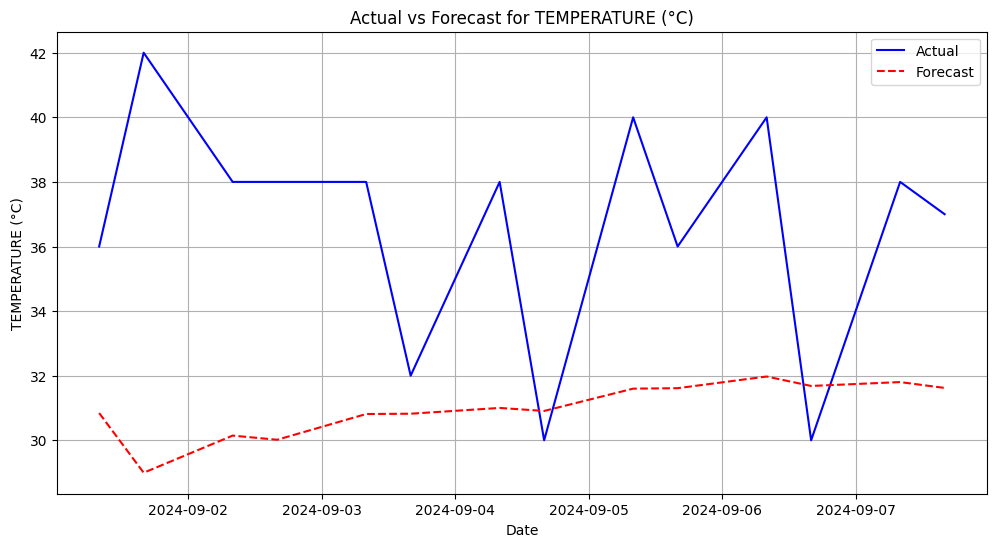

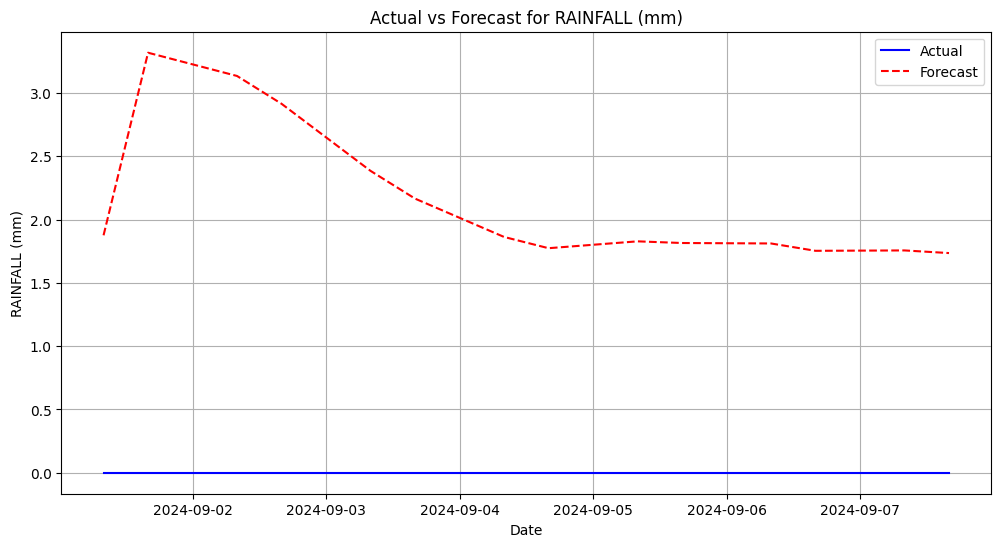

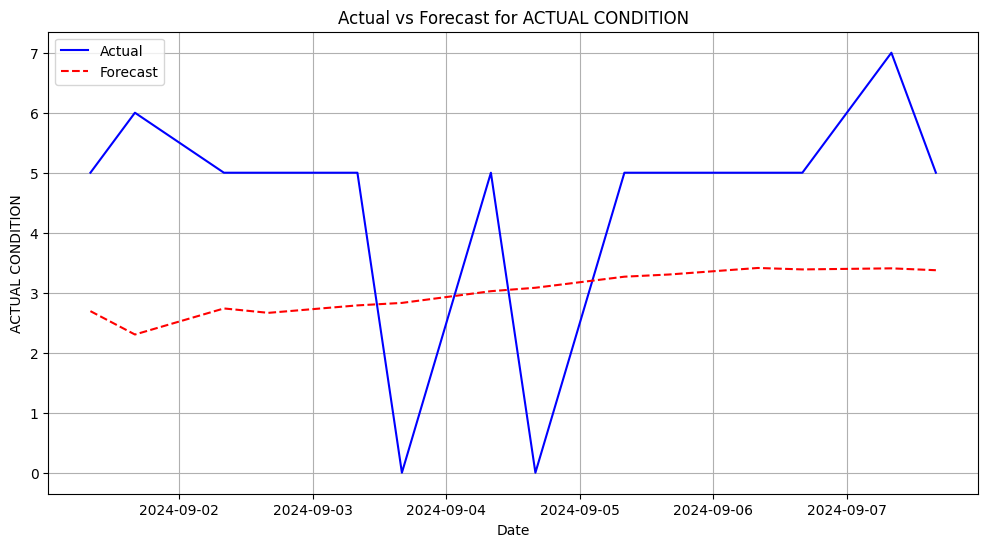

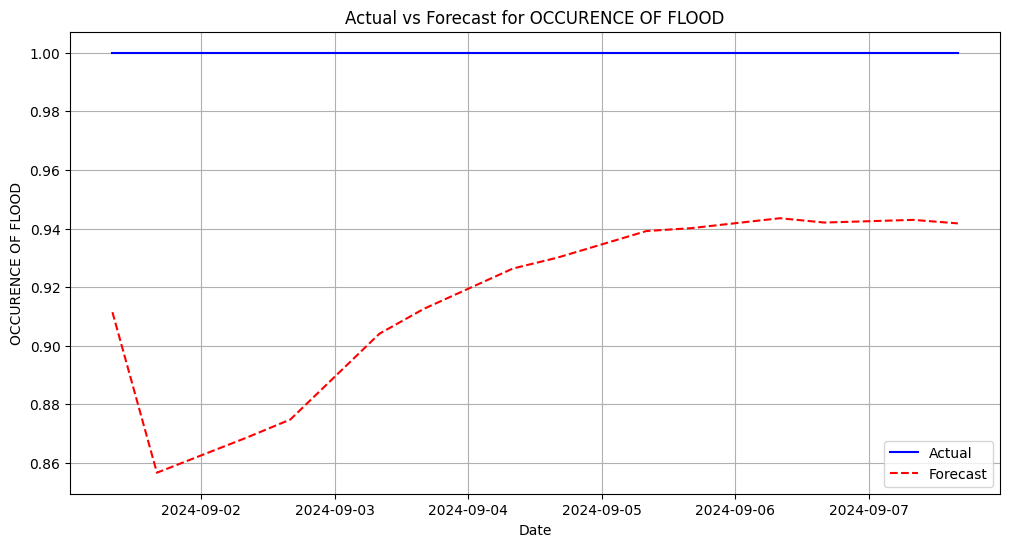

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Convert 'DATETIME' columns to datetime objects for proper plotting and indexing
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])
forecast_results.index = pd.to_datetime(forecast_results.index)
print(forecast_results)

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
#forecast_df.set_index('DATETIME', inplace=True)

# Ensure that the indices align for comparison
common_index = actual_data.index.intersection(forecast_results.index)
actual_data = actual_data.loc[common_index]
forecast_results = forecast_results.loc[common_index]

# Check if the data is aligned properly
if actual_data.empty or forecast_results.empty:
    print("Error: No common indices found between actual and forecast data.")
else:
    # Calculate performance metrics
    metrics = {}
    for column in actual_data.columns:
        if column in forecast_results.columns:
            y_true = actual_data[column]
            y_pred = forecast_results[column]
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            metrics[column] = {'MAE': mae, 'RMSE': rmse}
            print(f"{column} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Plot actual vs forecasted values for visual comparison
    for column in actual_data.columns:
        if column in forecast_results.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(actual_data.index, actual_data[column], label='Actual', color='blue')
            plt.plot(forecast_results.index, forecast_results[column], label='Forecast', color='red', linestyle='--')
            plt.title(f'Actual vs Forecast for {column}')
            plt.xlabel('Date')
            plt.ylabel(column)
            plt.legend()
            plt.grid(True)
            plt.show()

In [ ]:
Performance Report: Hybrid LSTM-GRU Model
Model Architecture
The Hybrid LSTM-GRU model integrates the strengths of both Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) architectures. The model architecture can be summarized as follows:

Input Layer: Accepts sequences of past weather data with multiple features.
LSTM Layer:
150 units
Return sequences set to True to pass the output to the next layer
Dropout layer with a dropout rate of 0.2 to prevent overfitting.
GRU Layer:
150 units
Dropout layer with a dropout rate of 0.2 to further mitigate overfitting.
Dense Output Layer:
4 neurons corresponding to each target variable (TEMPERATURE, RAINFALL, ACTUAL CONDITION, OCCURRENCE OF FLOOD).
The architecture ensures that the model captures both long-term dependencies through LSTM and short-term dependencies through GRU, optimizing the forecasting accuracy.

Results
The performance of the Hybrid LSTM-GRU model is evaluated using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) metrics across four key features:

Feature            	MAE	    RMSE
TEMPERATURE (°C)	6.02	6.81
RAINFALL (mm)	    2.15	2.22
ACTUAL CONDITION	2.32	2.43
OCCURRENCE OF FLOOD	0.08	0.09
Interpretation of Results
TEMPERATURE (°C):

The MAE of 6.02 indicates that, on average, the model's predictions deviate from actual temperature values by about 6.02°C. The RMSE of 6.81 reflects the variability of the prediction errors, highlighting that some errors are significant.
RAINFALL (mm):

An MAE of 2.15 suggests a reasonable accuracy in predicting rainfall levels, with RMSE of 2.22 indicating some outlier predictions.
ACTUAL CONDITION:

The MAE of 2.32 implies that the model's categorical predictions deviate slightly from observed conditions. The RMSE of 2.43 suggests variability, possibly due to the model's handling of different weather states.
OCCURRENCE OF FLOOD:

The MAE of 0.08 indicates a very low average error in predicting flood occurrences, while an RMSE of 0.09 confirms that most predictions are quite close to actual occurrences.
Conclusion
The Hybrid LSTM-GRU model demonstrates promising performance in forecasting weather variables and flood occurrences. The architecture effectively utilizes both LSTM and GRU layers to leverage the advantages of each. While the model performs reasonably well, particularly for OCCURRENCE OF FLOOD, there is room for improvement, especially regarding temperature predictions.

Recommendations for Future Work
Data Augmentation: Incorporate additional historical weather data to enhance the model's learning and improve its predictive accuracy.
Hyperparameter Tuning: Explore different configurations of the model (e.g., varying the number of layers, units, and dropout rates) to optimize performance.
Feature Engineering: Investigate additional weather-related features that may contribute to better predictions.